In [1]:
# Import all the necessary modules needed to run the inference pipeline
import sys
import os

sys.path.append(os.path.abspath('..'))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
distance = [20, 60, 100, 140, 180, 220, 260]
time = [2.5,5,7.5,10,12.5,15,17.5,20]
time_labels = ["0-5","2.5-7.5","5-10","7.5-12.5","10-15","12.5-17.5","15-20","17.5-22.5"]
burn_in = 200
# This function reads in previously run data from walker inference pipeline, and outputs the observed bias mean and std\
# for the dataframe. The inputs are x,y which correspond to the file formats

def bias_param_samples_from_file(input_data_array):
    posterior_chain_array = input_data_array[0]  # Extracts the posterior chain array from the input_data array
    # Removes the burn-in, thins the posterior data and flattens the walkers into a single array
    flattened_chain = posterior_chain_array.get_chain(discard=burn_in, thin=10, flat=True)
    w = flattened_chain[:, 0]  # The weighting parameter from the walker posterior array
    #    p = input_data[:, 1]  # The weighting parameter from the walker posterior array
    b = flattened_chain[:, 2]  # The bias parameter from the walker posterior array
    obwt = (w * b)  # The observed bias parameter from the walker posterior array
    mean = np.mean(obwt)
    std = np.std(obwt)
    return mean, std

def bias_values_control(i, j): 
    input_data_array = np.load('../data/BP_inference/Single_wound_CTR_revision_bins{}{}.npy'.format(i,j), allow_pickle=True)
    return bias_param_samples_from_file(input_data_array)

def bias_values_mcr(i, j): 
    input_data_array = np.load('../data/BP_inference/Single_wound_MCR_revision_bins{}{}.npy'.format(i,j), allow_pickle=True)
    return bias_param_samples_from_file(input_data_array)

# def bias_values_halfwound_control(i, j): 
#     input_data_array = np.load('../data/BP_inference/Halfwound_control_bins{}{}.npy'.format(i,j), allow_pickle=True)
#     return bias_param_samples_from_file(input_data_array)

# def bias_values_halfwound_mcr(i, j): 
#     input_data_array = np.load('../data/BP_inference/Halfwound_mcr_bins{}{}.npy'.format(i,j), allow_pickle=True)
#     return bias_param_samples_from_file(input_data_array)


In [7]:
# plot some MCMC chains to check for a reasonable burn-in
sample_data = np.load('../data/BP_inference/Single_wound_MCR_revision_bins20.npy', allow_pickle=True)
posterior_chain_array = sample_data[0]  # Extracts the posterior chain array from the input_data array
# Removes the burn-in, thins the posterior data and flattens the walkers into a single array
chains = posterior_chain_array.get_chain(discard=0)

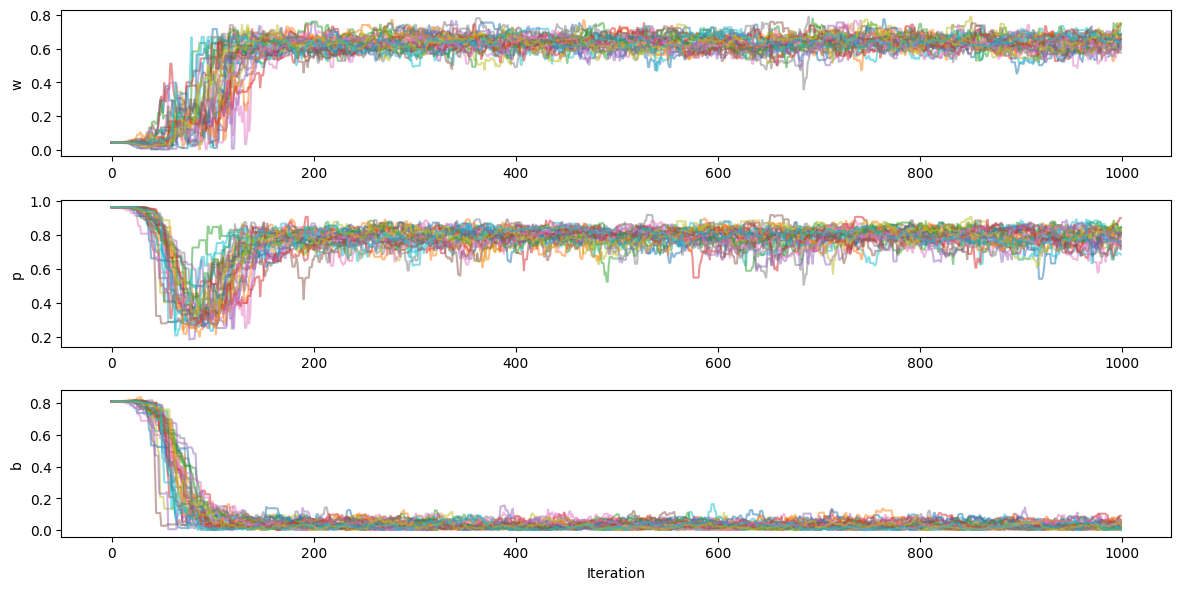

In [8]:

labels = ['w','p','b']#,'R0','κ','m','b0']
ndim = len(labels)
n_walkers = 30  

# Trace Plots
plt.figure(figsize=(12, 6))
for dim in range(ndim):
    plt.subplot(ndim, 1, dim + 1)
    for walker in range(n_walkers):
        plt.plot(chains[:, walker, dim], alpha=0.5)
    plt.ylabel(labels[dim])
plt.xlabel("Iteration")
plt.tight_layout()
plt.show()
# this seems to show a burn-in of about 200 is safe

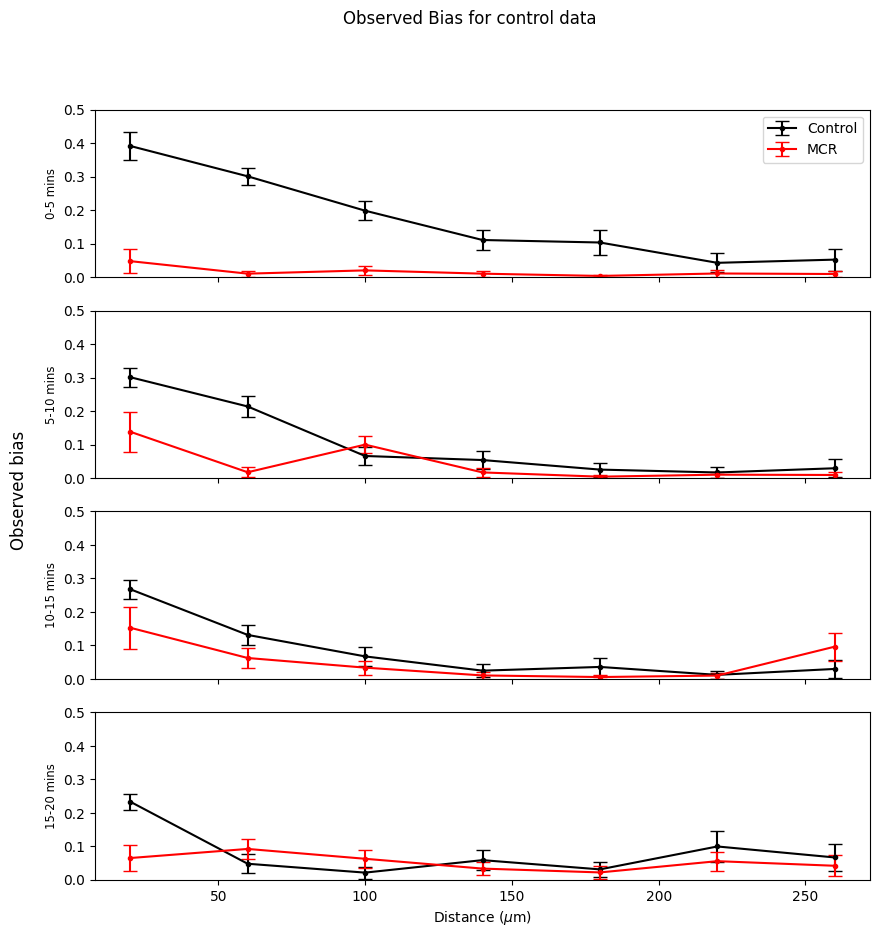

In [9]:

stepSizeTimeBins = 2
nTimeBins = int(np.round(len(time_labels)/stepSizeTimeBins))
fig, ax = plt.subplots(nTimeBins, 1, figsize=(10, 10), sharex=True)
fig.suptitle("Observed Bias for control data")
for i in range(nTimeBins):
    meansC = []
    stdsC = []
    meansM = []
    stdsM = []
    for j in range(len(distance)):
        ObBiasC = bias_values_control(j, i*stepSizeTimeBins)
        ObBiasM = bias_values_mcr(j, i*stepSizeTimeBins)

        meansC.append(ObBiasC[0])
        stdsC.append(ObBiasC[1])
        meansM.append(ObBiasM[0])
        stdsM.append(ObBiasM[1])
    ax[i].errorbar(distance,meansC,yerr = stdsC,marker='o',markersize = 3,capsize = 5,color = 'k', label = "Control")
    ax[i].errorbar(distance,meansM,yerr = stdsM,marker='o',markersize = 3,capsize = 5,color = 'r', label = "MCR")
    ax[i].set_ylim(0,0.5)
    ax[i].set_ylabel(f"{time_labels[i*stepSizeTimeBins]} mins", rotation=90, size='small')
plt.xlabel("Distance ($\mu$m)")
ax[0].legend(loc='upper right')

fig.text(0.04, 0.5, 'Observed bias', va='center', rotation='vertical', size = 'large')
plt.savefig("Figures/Observed bias control & mcr_revision_data_nonoverlappingbins.pdf")
plt.show()

In [10]:
# rearrange data to plot all time-points in one plot
obs_bias_control = []
for i in range(len(time_labels)):
    meansC = []
    stdsC = []
    for j in range(len(distance)):
        ObBiasC = bias_values_control(j, i)
        meansC.append(ObBiasC[0])
        stdsC.append(ObBiasC[1])
    obs_bias_control.append([meansC,stdsC])
np.shape(obs_bias_control) # dimensions are 8 time points, [mean, std], 7 distances

(8, 2, 7)

In [11]:
obs_bias_mcr = []
for i in range(len(time_labels)):
    meansM = []
    stdsM = []
    for j in range(len(distance)):
        ObBiasM = bias_values_mcr(j, i)
        meansM.append(ObBiasM[0])
        stdsM.append(ObBiasM[1])
    obs_bias_mcr.append([meansM,stdsM])
np.shape(obs_bias_mcr)# dimensions are 8 time points, [mean, std], 7 distances

(8, 2, 7)

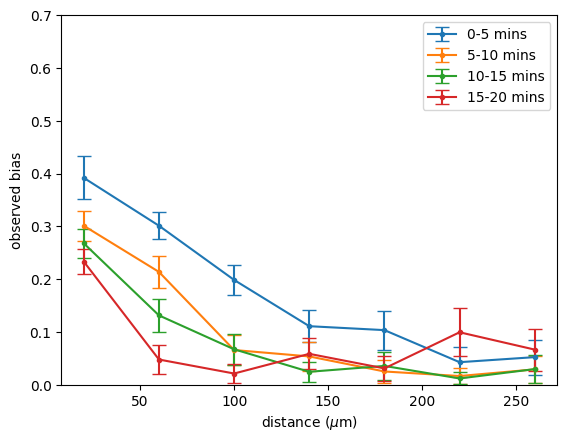

In [12]:
xoffset = 0#1.0
xoffsetstart = 0# -len(time_labels)/stepSizeTimeBins/2*xoffset
for i in range(0,len(time_labels),stepSizeTimeBins):
    plt.errorbar(np.array(distance)+xoffsetstart+i*xoffset, obs_bias_control[i][0], yerr=obs_bias_control[i][1],marker='o',markersize = 3,capsize = 5, label = f"{time_labels[i]} mins")
    
plt.legend()
plt.ylim(0,0.7)
plt.xlabel("distance ($\mu$m)")
plt.ylabel("observed bias")
plt.savefig("Figures/Observed_bias_control_revision.pdf")

plt.show()

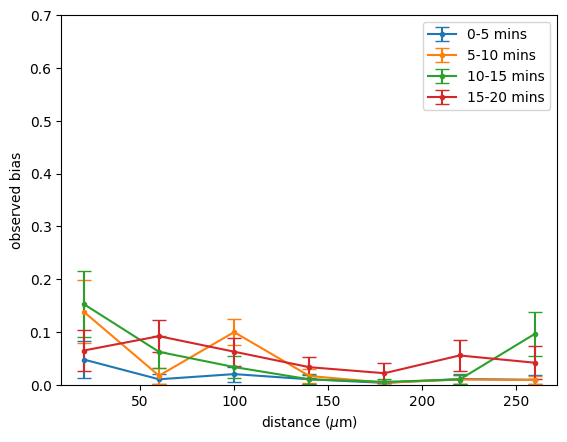

In [13]:
for i in range(0,len(time_labels),stepSizeTimeBins):
    plt.errorbar(np.array(distance)+xoffsetstart+i*xoffset, obs_bias_mcr[i][0], yerr=obs_bias_mcr[i][1],marker='o',markersize = 3,capsize = 5,label = f"{time_labels[i]} mins")
plt.legend()
plt.ylim(0,0.7)
plt.xlabel("distance ($\mu$m)")
plt.ylabel("observed bias")
plt.savefig("Figures/Observed_bias_mcr_revision.pdf")
plt.show()

In [16]:
# now plot observed bias for half-wound data on either side of wound at 10 and 20 min bins
# rearrange data to plot all time-points in one plot
obs_bias_halfwound_control = []
for i in range(len(time_labels)):
    meansC = []
    stdsC = []
    for j in range(len(distance)):
        ObBiasC = bias_values_halfwound_control(j, i)
        meansC.append(ObBiasC[0])
        stdsC.append(ObBiasC[1])
    obs_bias_halfwound_control.append([meansC,stdsC])
np.shape(obs_bias_halfwound_control) # dimensions are 8 time points, [mean, std], 7 distances

(8, 2, 7)

In [17]:
obs_bias_halfwound_mcr = []
for i in range(len(time_labels)):
    meansM = []
    stdsM = []
    for j in range(len(distance)):
        ObBiasM = bias_values_halfwound_mcr(j, i)
        meansM.append(ObBiasM[0])
        stdsM.append(ObBiasM[1])
    obs_bias_halfwound_mcr.append([meansM,stdsM])
np.shape(obs_bias_halfwound_mcr)# dimensions are 8 time points, [mean, std], 7 distances

(8, 2, 7)

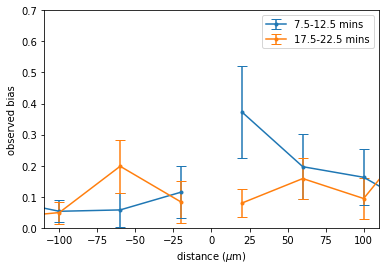

In [19]:
ax = plt.gca()
# for i in range(0,len(time_labels),stepSizeTimeBins):
for i in [3,7]:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.errorbar(np.array(distance)+xoffsetstart+i*xoffset, 
                 obs_bias_halfwound_control[i][0], 
                 yerr=obs_bias_halfwound_control[i][1],marker='o',markersize = 3,capsize = 5, color=color, label = f"{time_labels[i]} mins")
    plt.errorbar(-np.array(distance)+xoffsetstart+i*xoffset, 
                obs_bias_halfwound_mcr[i][0], 
                yerr=obs_bias_halfwound_mcr[i][1],marker='o',markersize = 3,capsize = 5, color=color)
    
plt.legend()
plt.ylim(0,0.7)
plt.xlim(-110,110)
plt.xlabel("distance ($\mu$m)")
plt.ylabel("observed bias")
plt.savefig("Figures/Observed_bias_halfwound.pdf")

plt.show()